# Implied Volatility of Index Options

In [1]:
import refinitiv.data as rd
from refinitiv.data.content import historical_pricing
from refinitiv.data.content.historical_pricing import Intervals
from refinitiv.data.content.historical_pricing import Adjustments
from refinitiv.data.content.historical_pricing import MarketSession
from refinitiv.data.content import search

import time
import numpy as np
import pandas as pd
import calendar
import pytz
import math
import pandas_market_calendars as mcal  # See `https://github.com/rsheftel/pandas_market_calendars/blob/master/examples/usage.ipynb` for info on this market calendar library
from datetime import datetime, timedelta, timezone
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import BDay
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px # This is just to see the implied vol graph when that field is available
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cbook as cbook
import matplotlib.ticker as ticker
from IPython.display import clear_output

try:  # The following libraries are not available in Codebook, thus this try loop
    rd.open_session(config_name="C:\\Example.DataLibrary.Python-main\\Example.DataLibrary.Python-main\\Configuration\\refinitiv-data.config.json")
    rd.open_session("desktop.workspace")
except:
    rd.open_session()

In [2]:
print(f"Here we are using the refinitiv Data Library version {rd.__version__}")

Here we are using the refinitiv Data Library version 1.0.0b20


In [3]:
def ImpVolatilityCalcIPA(x=15,
                         indexUnderlying=".STOXX50E",
                         callOrPut='Put',
                         dateBack=3,
                         expiryYearOfInterest=datetime.now().year,
                         riskFreeRate=None, riskFreeRateField=None,
                         timeZoneInGraph=datetime.now().astimezone(),
                         maxColwidth=200,
                         graphStyle='without out of trading hours',  # 'with out of trading hours', ''
                         graphTemplate='plotly_dark',
                         debug=False,
                         returnDfGraph=False,
                         simpleGraph=True,
                         AtOptionTradeOnly=False):


    if indexUnderlying == ".STOXX50E":
        exchangeC, exchangeRIC, mcalGetCalendar = 'EUX', 'STX', 'EUREX'
    elif indexUnderlying == '.SPX':
        exchangeC, exchangeRIC, mcalGetCalendar = 'OPQ', 'SPX', 'CBOE_Futures'# 'CBOE_Index_Options'  # should be 'CBOE_Index_Options'... CBOT_Equity


    def get_exp_dates(year=expiryYearOfInterest,
                      days=True,
                      mcal_get_calendar=mcalGetCalendar):
        '''
        get_exp_dates Version 3.0:

        This function gets expiration dates for a year for NDX options, which are the 3rd Fridays of each month.

        Changes
        ----------------------------------------------
        Changed from Version 1.0 to 2.0: Jonathan Legrand chaned Haykaz Aramyan's original code to allow
            (i) for the function's holiday argument to be changed, and defaulted to 'EUREX' as opposed to 'CBOE_Index_Options' and
            (ii) for the function to output full date objects as opposed to just days of the month if agument days=True.

        Changed from Version 2.0 to 3.0: Jonathan Legrand chaned this function to reflec tthe fact that it can be used for indexes other than EUREX.

        Dependencies
        ----------------------------------------------
        Python library 'pandas_market_calendars' version 3.2

        Parameters
        -----------------------------------------------
        Input:
            year(int): year for which expiration days are requested

            mcal_get_calendar(str): String of the calendar for which holidays have to be taken into account. More on this calendar (link to Github chacked 2022-10-11): https://github.com/rsheftel/pandas_market_calendars/blob/177e7922c7df5ad249b0d066b5c9e730a3ee8596/pandas_market_calendars/exchange_calendar_cboe.py
                Default: mcal_get_calendar='EUREX'

            days(bool): If True, only days of the month is outputed, else it's dataeime objects
                Default: days=True

        Output:
            dates(dict): dictionary of expiration days for each month of a specified year in datetime.date format.
        '''

        # get CBOE market holidays
        Cal = mcal.get_calendar(mcal_get_calendar)
        holidays = Cal.holidays().holidays

        # set calendar starting from Saturday
        c = calendar.Calendar(firstweekday=calendar.SATURDAY)

        # get the 3rd Friday of each month
        exp_dates = {}
        for i in range(1, 13):
            monthcal = c.monthdatescalendar(year, i)
            date = monthcal[2][-1]
            # check if found date is an holiday and get the previous date if it is
            if date in holidays:
                date = date + timedelta(-1)
            # append the date to the dictionary
            if year in exp_dates:
                ### Changed from original code from here on by Jonathan Legrand on 2022-10-11
                if days: exp_dates[year].append(date.day)
                else: exp_dates[year].append(date)
            else:
                if days: exp_dates[year] = [date.day]
                else: exp_dates[year] = [date]
        return exp_dates

    timeOfCalcDatetime = datetime.now()  # For now, we will focuss on the use-case where we are calculating values for today; later we will allow for it historically for any day going back a few business days.
    timeOfCalcStr = datetime.now().strftime('%Y-%m-%d')
    fullDatesAtTimeOfCalc = get_exp_dates(timeOfCalcDatetime.year, days=False)  # `timeOfCalcDatetime.year` here is 2022
    fullDatesAtTimeOfCalcDatetime = [
        datetime(i.year, i.month, i.day)
        for i in fullDatesAtTimeOfCalc[list(fullDatesAtTimeOfCalc.keys())[0]]]
    expiryDateOfInt = [i for i in fullDatesAtTimeOfCalcDatetime
                       if i > timeOfCalcDatetime + relativedelta(days=x)][0]

    if debug: print(f"expiryDateOfInt: {expiryDateOfInt}")

    response = search.Definition(
        view = search.Views.SEARCH_ALL, # To see what views are available: `help(search.Views)` & `search.metadata.Definition(view = search.Views.SEARCH_ALL).get_data().data.df.to_excel("SEARCH_ALL.xlsx")`
        query=indexUnderlying,
        select="DocumentTitle, RIC, StrikePrice, ExchangeCode, ExpiryDate, UnderlyingAsset, " +
                "UnderlyingAssetName, UnderlyingAssetRIC, ESMAUnderlyingIndexCode, RCSUnderlyingMarket" +
                "UnderlyingQuoteName, UnderlyingQuoteRIC",
        filter=f"RCSAssetCategoryLeaf eq 'Option' and RIC eq '{exchangeRIC}*' and DocumentTitle ne '*Weekly*' " +
        f"and CallPutOption eq '{callOrPut}' and ExchangeCode eq '{exchangeC}' and " +
        f"ExpiryDate ge {(expiryDateOfInt - relativedelta(days=1)).strftime('%Y-%m-%d')} " +
        f"and ExpiryDate lt {(expiryDateOfInt + relativedelta(days=1)).strftime('%Y-%m-%d')}",  # ge (greater than or equal to), gt (greater than), lt (less than) and le (less than or equal to). These can only be applied to numeric and date properties.
        top=10000,
    ).get_data()
    searchDf = response.data.df

    if debug: display(searchDf)

    try:
        underlyingPrice =  rd.get_history(
            universe=[indexUnderlying],
            fields=["TRDPRC_1"],
            interval="tick").iloc[-1][0]
    except:
        print("Function failed at the search strage, returning the following dataframe: ")
        display(searchDf)

    if debug:
        print(f"Underlying {indexUnderlying}'s price recoprded here was {underlyingPrice}")
        display(searchDf.iloc[(searchDf['StrikePrice']-underlyingPrice).abs().argsort()[:10]])

    instrument = searchDf.iloc[(searchDf['StrikePrice']-underlyingPrice).abs().argsort()[:1]].RIC.values[0]

    start = (timeOfCalcDatetime - pd.tseries.offsets.BDay(dateBack)).strftime('%Y-%m-%dT%H:%M:%S.%f')  # '2022-10-05T07:30:00.000'
    endDateTime = datetime.now()
    end = endDateTime.strftime('%Y-%m-%dT%H:%M:%S.%f')  #  e.g.: '2022-09-09T20:00:00.000'

    _optnMrktPrice = rd.get_history(
        universe=[instrument],
        fields=["TRDPRC_1"],
        interval="10min",
        start=start,  # Ought to always start at 4 am for OPRA exchanged Options, more info in the article below
        end=end)  # Ought to always end at 8 pm for OPRA exchanged Options, more info in the article below

    if debug: print(instrument)
    if debug: display(_optnMrktPrice)

    ## Data on certain options are stale and do not nessesarily show up on Workspace, in case that happens, we will pick the next ATM Option, which probably will have the same strike, but we will only do so once, any more and we could get too far from strike:
    if _optnMrktPrice.empty:
        if debug: print(f"No data could be found for {instrument}, so the next ATM Option was chosen")
        instrument = searchDf.iloc[(searchDf['StrikePrice']-underlyingPrice).abs().argsort()[1:2]].RIC.values[0]
        if debug: print(f"{instrument}")
        _optnMrktPrice = rd.get_history(universe=[instrument],
                                        fields=["TRDPRC_1"], interval="10min",
                                        start=start, end=end)
        if debug: display(_optnMrktPrice)
    if _optnMrktPrice.empty:  # Let's try one more time, as is often nessesary
        if debug: print(f"No data could be found for {instrument}, so the next ATM Option was chosen")
        instrument = searchDf.iloc[(searchDf['StrikePrice']-underlyingPrice).abs().argsort()[2:3]].RIC.values[0]
        if debug: print(f"{instrument}")
        _optnMrktPrice = rd.get_history(universe=[instrument],
                                        fields=["TRDPRC_1"], interval="10min",
                                        start=start, end=end)
        if debug: display(_optnMrktPrice)
    if _optnMrktPrice.empty:
        print(f"No data could be found for {instrument}, please check it on Refinitiv Workspace")

    optnMrktPrice = _optnMrktPrice.resample('10Min').mean() # get a datapoint every 10 min
    optnMrktPrice = optnMrktPrice[optnMrktPrice.index.strftime('%Y-%m-%d').isin([i for i in _optnMrktPrice.index.strftime('%Y-%m-%d').unique()])]  # Only keep trading days
    optnMrktPrice = optnMrktPrice.loc[(optnMrktPrice.index.strftime('%H:%M:%S') >= '07:30:00') & (optnMrktPrice.index.strftime('%H:%M:%S') <= '22:00:00')]  # Only keep trading hours
    optnMrktPrice.fillna(method='ffill', inplace=True)  # Forward Fill to populate NaN values

    # Note also that one may want to only look at 'At Option Trade' datapoints,
    # i.e.: Implied Volatility when a trade is made for the Option, but not when
    # none is made. For this, we will use the 'At Trade' (`AT`) dataframes:
    if AtOptionTradeOnly: AToptnMrktPrice = _optnMrktPrice

    underlying = searchDf.iloc[(searchDf['StrikePrice']).abs().argsort()[:1]].UnderlyingQuoteRIC.values[0][0]

    _underlyingMrktPrice = rd.get_history(
        universe=[underlying],
        fields=["TRDPRC_1"],
        interval="10min",
        start=start,
        end=end)
    # Let's put it al in one data-frame, `df`. Some datasets will have data
    # going from the time we sert for `start` all the way to `end`. Some won't
    # because no trade happened in the past few minutes/hours. We ought to base
    # ourselves on the dataset with values getting closer to `end` and `ffill`
    # for the other column. As a result, the following `if` loop is needed:
    if optnMrktPrice.index[-1] >= _underlyingMrktPrice.index[-1]:
        df = optnMrktPrice.copy()
        df['underlying ' + underlying + ' TRDPRC_1'] = _underlyingMrktPrice
    else:
        df = _underlyingMrktPrice.copy()
        df.rename(
            columns={"TRDPRC_1": 'underlying ' + underlying + ' TRDPRC_1'},
            inplace=True)
        df['TRDPRC_1'] = optnMrktPrice
        df.columns.name = optnMrktPrice.columns.name
    df.fillna(method='ffill', inplace=True)  # Forward Fill to populate NaN values
    df = df.dropna()

    if AtOptionTradeOnly:
        ATunderlyingMrktPrice = AToptnMrktPrice.join(
            _underlyingMrktPrice, lsuffix='_OptPr', rsuffix=' Underlying ' + underlying + ' TRDPRC_1', how='inner')
        ATdf = ATunderlyingMrktPrice

    strikePrice = searchDf.iloc[(searchDf['StrikePrice']-underlyingPrice).abs().argsort()[:1]].StrikePrice.values[0]

    if riskFreeRate is None and indexUnderlying == ".SPX":
        _riskFreeRate = 'USDCFCFCTSA3M='
        _riskFreeRateField = 'TR.FIXINGVALUE'
    elif riskFreeRate is None and indexUnderlying == ".STOXX50E":
        _riskFreeRate = 'EURIBOR3MD='
        _riskFreeRateField = 'TR.FIXINGVALUE'
    else:
        _riskFreeRate, _riskFreeRateField = riskFreeRate, riskFreeRateField

    _RfRate = rd.get_history(
        universe=[_riskFreeRate],  # USD3MFSR=, USDSOFR=
        fields=[_riskFreeRateField],
        # Since we will use `dropna()` as a way to select the rows we are after later on in the code, we need to ask for more risk-free data than needed, just in case we don't have enough:
        start=(datetime.strptime(start, '%Y-%m-%dT%H:%M:%S.%f') - timedelta(days=1)).strftime('%Y-%m-%d'),
        end=(datetime.strptime(end, '%Y-%m-%dT%H:%M:%S.%f') + timedelta(days=1)).strftime('%Y-%m-%d'))

    RfRate = _RfRate.resample('10Min').mean().fillna(method='ffill')
    df['RfRate'] = RfRate
    df = df.fillna(method='ffill')

    if AtOptionTradeOnly:
        pd.options.mode.chained_assignment = None  # default='warn'
        ATunderlyingMrktPrice['RfRate'] = [pd.NA for i in ATunderlyingMrktPrice.index]
        for i in RfRate.index:
            _i = str(i)[:10]
            for n, j in enumerate(ATunderlyingMrktPrice.index):
                if _i in str(j):
                    if len(RfRate.loc[i].values)==2:
                        ATunderlyingMrktPrice['RfRate'].iloc[n] = RfRate.loc[i].values[0][0]
                    elif len(RfRate.loc[i].values)==1:
                        ATunderlyingMrktPrice['RfRate'].iloc[n] = RfRate.loc[i].values[0]
        ATdf = ATunderlyingMrktPrice.copy()

    if timeZoneInGraph != 'GMT':
        df.index = [
            df.index[i].replace(
                tzinfo=pytz.timezone(
                    'GMT')).astimezone(
                tz=timeZoneInGraph.tzinfo)
            for i in range(len(df))]
        if AtOptionTradeOnly:
            ATdf.index = [
                ATdf.index[i].replace(
                    tzinfo=pytz.timezone(
                        'GMT')).astimezone(
                    tz=datetime.now().astimezone().tzinfo)
                for i in range(len(ATdf))]

    universeL = [
        {
          "instrumentType": "Option",
          "instrumentDefinition": {
            "buySell": "Buy",
            "underlyingType": "Eti",
            "instrumentCode": instrument,
            "strike": str(strikePrice),
          },
          "pricingParameters": {
            "marketValueInDealCcy": str(df['TRDPRC_1'][i]),
            "riskFreeRatePercent": str(df['RfRate'][i]),
            "underlyingPrice": str(df['underlying ' + underlying + ' TRDPRC_1'][i]),
            "pricingModelType": "BlackScholes",
            "dividendType": "ImpliedYield",
            "volatilityType": "Implied",
            "underlyingTimeStamp": "Default",
            "reportCcy": "EUR"
          }
        }
      for i in range(len(df.index))]

    if AtOptionTradeOnly:
        ATuniverseL = [
            {
              "instrumentType": "Option",
              "instrumentDefinition": {
                "buySell": "Buy",
                "underlyingType": "Eti",
                "instrumentCode": instrument,
                "strike": str(strikePrice),
              },
              "pricingParameters": {
                "marketValueInDealCcy": str(ATdf['TRDPRC_1_OptPr'][i]),
                "riskFreeRatePercent": str(ATdf['RfRate'][i]),
                "underlyingPrice": str(ATdf['TRDPRC_1 Underlying ' + underlying + ' TRDPRC_1'][i]),
                "pricingModelType": "BlackScholes",
                "dividendType": "ImpliedYield",
                "volatilityType": "Implied",
                "underlyingTimeStamp": "Default",
                "reportCcy": "EUR"
              }
            }
          for i in range(len(ATdf.index))]

    def chunks(lst, n):
        """Yield successive n-sized chunks from lst."""
        for i in range(0, len(lst), n):
            yield lst[i:i + n]

    requestFields = [
        "MarketValueInDealCcy", "RiskFreeRatePercent",
        "UnderlyingPrice", "PricingModelType",
        "DividendType", "VolatilityType",
        "UnderlyingTimeStamp", "ReportCcy",
        "VolatilityType", "Volatility",
        "DeltaPercent", "GammaPercent",
        "RhoPercent", "ThetaPercent",
        "VegaPercent"]

    if AtOptionTradeOnly: universeL = ATuniverseL
    for i, j in enumerate(chunks(universeL, 100)):
        # Example request with Body Parameter - Symbology Lookup
        request_definition = rd.delivery.endpoint_request.Definition(
            method=rd.delivery.endpoint_request.RequestMethod.POST,
            url='https://api.refinitiv.com/data/quantitative-analytics/v1/financial-contracts',
            body_parameters={
                "fields": requestFields,
                "outputs": ["Data", "Headers"],
                "universe": j})
        response2 = request_definition.get_data()
        headers_name = [h['name'] for h in response2.data.raw['headers']]
        if i == 0:
            response2df = pd.DataFrame(data=response2.data.raw['data'], columns=headers_name)
        else:
            _response2df = pd.DataFrame(data=response2.data.raw['data'], columns=headers_name)
            response2df = response2df.append(_response2df, ignore_index=True)

    IPADf = response2df.copy()
    if AtOptionTradeOnly:
        IPADf.index = ATdf.index
        IPADf.columns.name = ATdf.columns.name
    else:
        IPADf.index = df.index
        IPADf.columns.name = df.columns.name
    IPADf.rename(columns={"Volatility": 'ImpliedVolatility'}, inplace=True)

    if simpleGraph:
        # IPADf[['ImpliedVolatility']].plot()
        display(searchDf.iloc[(searchDf['StrikePrice']-underlyingPrice).abs().argsort()[:1]])
        fig, axes = plt.subplots(ncols=1)
        # write a custom formatter
        N = len(IPADf[['ImpliedVolatility']])
        ind = np.arange(N)  # the evenly spaced plot indices
        def format_date(x, pos=None):
            thisind = np.clip(int(x + 0.5), 0, N - 1)
            return IPADf[['ImpliedVolatility']].index[thisind].strftime('%Y-%m-%d %Hh')
        axes.plot(ind, IPADf[['ImpliedVolatility']].ImpliedVolatility, 'o-')
        axes.xaxis.set_major_formatter(ticker.FuncFormatter(format_date))
        axes.set_title(f"{instrument} Implied Volatility At Trade Only")
        fig.autofmt_xdate()

        plt.show()
        
    else:

        pd.options.display.max_colwidth = maxColwidth
        display(searchDf.iloc[(searchDf['StrikePrice']-underlyingPrice).abs().argsort()[:1]])

        IPADfGraph = IPADf[['ImpliedVolatility', 'MarketValueInDealCcy',
                            'RiskFreeRatePercent', 'UnderlyingPrice', 'DeltaPercent',
                            'GammaPercent', 'RhoPercent', 'ThetaPercent', 'VegaPercent']]

        if debug: display(IPADfGraph)

        try: # his is needed in case there is not enough data to calculate values for all timestamps , see https://stackoverflow.com/questions/67244912/wide-format-csv-with-plotly-express
            fig = px.line(IPADfGraph)
        except:
            if returnDfGraph:
                return IPADfGraph
            else:
                IPADfGraph = IPADfGraph[["ImpliedVolatility","MarketValueInDealCcy","RiskFreeRatePercent","UnderlyingPrice"]]
                fig = px.line(IPADfGraph)

        if graphStyle=='without out of trading hours':
            fig.layout = dict(xaxis=dict(type="category"))
            # Format Graph: https://plotly.com/python/tick-formatting/
            fig.update_layout(
                title=instrument,
                template='plotly_dark',
                xaxis=dict(
                    tickmode='array',
                    tickvals=list(
                        range(len(IPADfGraph.index)))[0::35],  # Thought of replacing `35` with `math.ceil(len(IPADfGraph.index)/10)`
                    ticktext=[IPADf.index[i] for i in list(
                        range(len(IPADfGraph.index)))[0::35]]))
            # Make it so that only one line is shown by default: # https://stackoverflow.com/questions/73384807/plotly-express-plot-subset-of-dataframe-columns-by-default-and-the-rest-as-opt
            fig.for_each_trace(
                lambda t: t.update(
                    visible=True if t.name in IPADfGraph.columns[:1] else "legendonly"))

        # elif graphStyle=='with out of trading hours':
        #     fig.update_layout(
        #         title=instrument,
        #         template=graphTemplate)
        #     fig.for_each_trace(
        #         lambda t: t.update(
        #             visible=True if t.name in IPADfGraph.columns[:1] else "legendonly"))

        else:
            fig = make_subplots(rows=3, cols=1)

            fig.add_trace(go.Scatter(x=IPADf.index, y=IPADf.ImpliedVolatility, name='Op Imp Volatility'), row=1, col=1)
            fig.add_trace(go.Scatter(x=IPADf.index, y=IPADf.MarketValueInDealCcy, name='Op Mk Pr'), row=2, col=1)
            fig.add_trace(go.Scatter(x=IPADf.index, y=IPADf.UnderlyingPrice, name=underlying+' Undrlyg Pr'), row=3, col=1)

            fig.update(layout_xaxis_rangeslider_visible=False)
            fig.update_layout(title=IPADf.columns.name)
            fig.update_layout(
                template=graphTemplate,
                autosize=False,
                width=1300,
                height=500)

        fig.show()

In [4]:
# ImpVolatilityCalcIPA( # This will pick up 10 min data
#     x=15,
#     indexUnderlying=".SPX",  # ".SPX" or ".STOXX50E"
#     callOrPut='Call',
#     riskFreeRate=None,
#     riskFreeRateField=None,  # 'TR.FIXINGVALUE'
#     graphStyle='without out of trading hours',
#     debug=False,
#     simpleGraph=True,
#     AtOptionTradeOnly=True)

2022-11-29 11:14:50.697663


,DocumentTitle,RIC,StrikePrice,ExchangeCode,ExpiryDate,UnderlyingQuoteRIC
788,"OPRA S&P 500 Index Option 3965 Call Dec 2022 ,...",SPXWl162239650.U,3965,OPQ,2022-12-16,[.SPX]


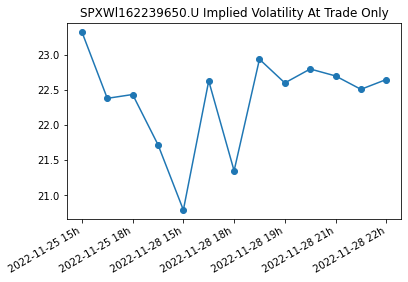

In [ ]:
while True:
    # Code executed here
    clear_output(wait=True)
    print(datetime.now())
    try:
        ImpVolatilityCalcIPA(
            x=15,  # Number of days after which we start searching for Options' Expiries
            dateBack=3,  # Number of business days for which the chart will show data
            indexUnderlying=".SPX",  # ".SPX" or ".STOXX50E"
            callOrPut='Call',  # 'Call' or 'Put'
            simpleGraph=True,
            AtOptionTradeOnly=True)
        time.sleep(60*10)
    except:
        try:
            ImpVolatilityCalcIPA(
                x=15,  # Number of days after which we start searching for Options' Expiries
                dateBack=3,  # Number of business days for which the chart will show data
                indexUnderlying=".SPX",  # ".SPX" or ".STOXX50E"
                callOrPut='Call',  # 'Call' or 'Put'
                simpleGraph=True,
                AtOptionTradeOnly=False)
            print("NOTE THAT 'AtOptionTradeOnly' WAS SET TO 'False'")
            time.sleep(60*10)
        except:
            print("Please wait for next roll")